In [119]:
import numpy as np

In [120]:
class Dense_Layer:
    def __init__(self,ninputs,nneurons):
        # Initialising weights and biases
        self.weights = 0.01 * np.random.randn(ninputs,nneurons)
        self.biases = np.zeros((1,nneurons))
        
    # Forward Propagation    
    def forward(self,inputs):
        self.output = np.dot(inputs,self.weights) + self.biases
        self.inputs = inputs
    
    # Backpropagation
    def backward(self,dvalues):
        self.dinputs = np.dot(dvalues,self.weights.T)
        self.dweights = np.dot(self.inputs.T,dvalues)
        self.dbiases = np.sum(dvalues,axis=0,keepdims=True)

In [121]:
class Activation_Relu:
    def forward(self,inputs):
        self.output = np.maximum(0,inputs)
        self.inputs = inputs
    
    def backward(self,dvalues):
        self.dinputs = dvalues.copy()
        self.dinputs[self.inputs <= 0] = 0
        

In [122]:
class Activation_Softmax:
    def forward(self,inputs,y_true):
        expvals = np.exp(inputs - np.max(inputs, axis=1,
        keepdims=True) )
        self.output = expvals/np.sum(expvals,axis=1,keepdims=True)

In [123]:
class CrossEntropyLoss:
    def calculate(self,y_pred,y_true):
        # Turning one hot encoded values into sparse vectors
        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true,axis=1)
        
        # Clipping to prevent log with 0
        ypred = np.clip(y_pred,1e-7,1-1e-7)
        
        return np.mean(-np.log(y_pred[range(len(y_pred)),y_true]))
    


In [124]:
class Activation_softmax_cross_entropy:
    def __init__(self):
        self.activation = Activation_Softmax()
        self.lossfunc = CrossEntropyLoss()
    
    def forward(self,inputs,y_true):
        self.activation.forward(inputs,y_true)
        self.output = self.activation.output
        return self.lossfunc.calculate(self.output,y_true)
    
    def backward(self,dvalues,y_true):
        samples = len(y_true)
        
        # Turning one hot encoded arrays to sparse vectors
        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true,axis=1)
        
        self.dinputs = dvalues.copy()
        self.dinputs[range(samples),y_true] -= 1
        
        self.dinputs/=samples

In [125]:
class SGD_Optimizer:
    def __init__(self,lr=1,decay_rate=0.1,momentum=0.):
        self.initiallr = lr
        self.currentlr = lr
        self.decay_rate = decay_rate
        self.iterations = 0
        self.momentum = momentum
    
    def pre_update(self):
        self.currentlr = self.initiallr * (1/(1+(self.decay_rate * self.iterations)))

    def update_params(self,layer):
        
        if self.momentum:
            # if we don't have momentum arrays create them
            if not hasattr(layer, 'weight_momentums'):
                layer.weight_momentums = np.zeros_like(layer.weights)
                
                layer.bias_momentums = np.zeros_like(layer.biases)
            
            weight_updates = \
                self.momentum * layer.weight_momentums - self.currentlr * layer.dweights
            layer.weight_momentums = weight_updates
            
            bias_updates = \
                self.momentum * layer.bias_momentums - self.currentlr * layer.dbiases
            layer.bias_momentums = bias_updates
            
        else:
            weight_updates = -self.currentlr * layer.dweights
            bias_updates = -self.currentlr * layer.dbiases
                
        
        layer.weights += weight_updates
        layer.biases += bias_updates
        
    def post_update(self):
        self.iterations += 1

In [126]:
class Adagrad_Optimizer:
    def __init__(self,lr=1,decay_rate=0,epsilon = 1e-7):
        self.initiallr = lr
        self.currentlr = lr
        self.decay_rate = decay_rate
        self.iterations = 0
        self.epsilon = epsilon
    
    def pre_update(self):
        self.currentlr = self.initiallr * (1/(1+(self.decay_rate * self.iterations)))

    def update_params(self,layer):
        
        if not hasattr(layer,'weight_cache'):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)
        
        layer.weight_cache += (layer.dweights ** 2)
        layer.bias_cache += (layer.dbiases ** 2)
        
        layer.weights += - self.currentlr * layer.dweights  / (np.sqrt(layer.weight_cache) + self.epsilon)
        layer.biases += -self.currentlr * layer.dbiases / (np.sqrt(layer.bias_cache) + self.epsilon)
        
    def post_update(self):
        self.iterations += 1

In [127]:
class RMSProp_Optimizer:
    def __init__(self,lr=0.001,decay_rate=0,epsilon = 1e-7,rho=0.9):
        self.initiallr = lr
        self.currentlr = lr
        self.decay_rate = decay_rate
        self.iterations = 0
        self.epsilon = epsilon
        self.rho = rho
    
    def pre_update(self):
        self.currentlr = self.initiallr * (1/(1+(self.decay_rate * self.iterations)))

    def update_params(self,layer):
        
        if not hasattr(layer,'weight_cache'):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)
        
        layer.weight_cache = layer.weight_cache * self.rho + (1-self.rho) * (layer.dweights ** 2)
        layer.bias_cache = layer.bias_cache * self.rho + (1-self.rho) * (layer.dbiases ** 2)
        
        layer.weights += - self.currentlr * layer.dweights  / (np.sqrt(layer.weight_cache) + self.epsilon)
        layer.biases += -self.currentlr * layer.dbiases / (np.sqrt(layer.bias_cache) + self.epsilon)
        
    def post_update(self):
        self.iterations += 1

In [173]:
class Adam_Optimizer:
    def __init__(self,lr=0.001,decay_rate=0,epsilon= 1e-7,beta1=0.9,beta2=0.999):
        self.initiallr = lr
        self.currentlr = lr
        self.decay_rate = decay_rate
        self.iterations = 0
        self.epsilon = epsilon
        self.beta1 = beta1
        self.beta2 = beta2
    
    def pre_update(self):
        self.currentlr = self.initiallr * (1/(1+(self.decay_rate * self.iterations)))

    def update_params(self,layer):
        
        if not hasattr(layer,'weight_cache'):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.biases)
            layer.weight_momentum = np.zeros_like(layer.weights)
            layer.bias_momentum = np.zeros_like(layer.biases)
            
        layer.weight_momentum = self.beta1 * layer.weight_momentum + (1-self.beta1) * layer.dweights
        layer.bias_momentum = self.beta1 * layer.bias_momentum + (1 - self.beta1) * layer.dbiases
        
        layer.weight_momentum_prime = layer.weight_momentum / (1 - self.beta1 ** (self.iterations + 1))
        layer.bias_momentum_prime = layer.bias_momentum / (1 - self.beta1 ** (self.iterations + 1))
        
        layer.weight_cache = layer.weight_cache * self.beta2 + (1-self.beta2) * (layer.dweights ** 2)
        layer.bias_cache = layer.bias_cache * self.beta2 + (1-self.beta2) * (layer.dbiases ** 2)
        
        layer.weight_cache_prime = layer.weight_cache / (1 - self.beta2 ** (self.iterations + 1))
        layer.bias_cache_prime = layer.bias_cache / (1 - self.beta2 ** (self.iterations + 1))

        layer.weights += - self.currentlr * layer.weight_momentum_prime  / (np.sqrt(layer.weight_cache_prime) + self.epsilon)
        layer.biases += -self.currentlr * layer.bias_momentum_prime / (np.sqrt(layer.bias_cache_prime) + self.epsilon)
        
    def post_update(self):
        self.iterations += 1

In [129]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_circles

In [130]:
X,y = make_circles(n_samples=1000,noise=.05)

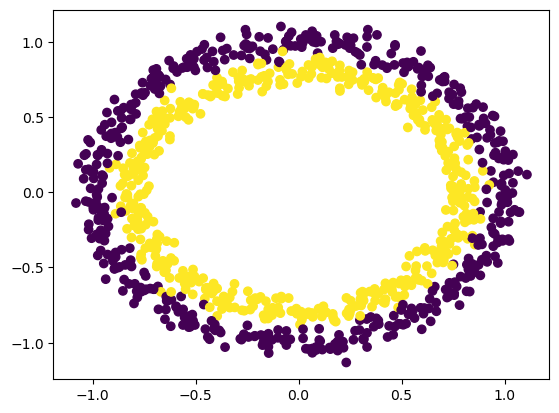

In [131]:
plt.scatter(X[:,0],X[:,1],c=y)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
...     X, y, test_size=0.33, random_state=42)

In [17]:
layer1 = Dense_Layer(2,64)
act = Activation_Relu()
layer2 = Dense_Layer(64,2)
actloss = Activation_softmax_cross_entropy()
optimizer = SGD_Optimizer(1,decay_rate=1e-3,momentum=0.5)

for epoch in range(1001):
    layer1.forward(X_train)
    act.forward(layer1.output)
    layer2.forward(act.output)
    loss = actloss.forward(layer2.output,y_train)
    
    y_pred = np.argmax(actloss.output,axis=1)
    
    acc = np.mean(y_pred == y_train)
    if epoch % 100 == 0:
        print("Epoch : ",epoch, " Accuracy : ",acc, " Loss : ",loss)
    
    actloss.backward(actloss.output,y_train)
    layer2.backward(actloss.dinputs)
    act.backward(layer2.dinputs)
    layer1.backward(act.dinputs)

    optimizer.update_params(layer1)
    optimizer.update_params(layer2)

Epoch :  0  Accuracy :  0.5074626865671642  Loss :  0.6931375535784944
Epoch :  100  Accuracy :  0.935820895522388  Loss :  0.5051123645703605
Epoch :  200  Accuracy :  0.9850746268656716  Loss :  0.1353215879916105
Epoch :  300  Accuracy :  0.9865671641791045  Loss :  0.07037692852899127
Epoch :  400  Accuracy :  0.9880597014925373  Loss :  0.0527870444533208
Epoch :  500  Accuracy :  0.9880597014925373  Loss :  0.04503055736814187
Epoch :  600  Accuracy :  0.9880597014925373  Loss :  0.04072176763583506
Epoch :  700  Accuracy :  0.9865671641791045  Loss :  0.0379726970879829
Epoch :  800  Accuracy :  0.9865671641791045  Loss :  0.03604849220735641
Epoch :  900  Accuracy :  0.9865671641791045  Loss :  0.03464716296561357
Epoch :  1000  Accuracy :  0.9865671641791045  Loss :  0.033587268101153825


In [132]:
import nnfs
from nnfs.datasets import spiral_data

In [133]:
np.random.seed(0)

In [134]:
X,y = spiral_data(samples=100,classes=3)

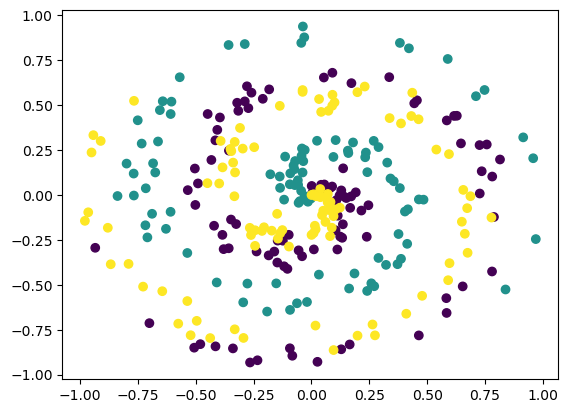

In [135]:
plt.scatter(X[:,0],X[:,1],c=y)

# SGD with momentum

In [50]:
layer1 = Dense_Layer(2,64)
act = Activation_Relu()
layer2 = Dense_Layer(64,3)
actloss = Activation_softmax_cross_entropy()
optimizer = SGD_Optimizer(1,decay_rate=0.001,momentum=0.9)

for epoch in range(10001):
    layer1.forward(X)
    act.forward(layer1.output)
    layer2.forward(act.output)
    loss = actloss.forward(layer2.output,y)
    
    y_pred = np.argmax(actloss.output,axis=1)
    
    acc = np.mean(y_pred == y)
    if epoch % 1000 == 0:
        print("Epoch : ",epoch, " Accuracy : ",acc, " Loss : ",loss)
    
    actloss.backward(actloss.output,y)
    layer2.backward(actloss.dinputs)
    act.backward(layer2.dinputs)
    layer1.backward(act.dinputs)

    optimizer.pre_update()
    optimizer.update_params(layer1)
    optimizer.update_params(layer2)
    optimizer.post_update()

Epoch :  0  Accuracy :  0.25  Loss :  1.0986372020152781
Epoch :  1000  Accuracy :  0.8833333333333333  Loss :  0.31818374461628013
Epoch :  2000  Accuracy :  0.91  Loss :  0.255988447840704
Epoch :  3000  Accuracy :  0.9233333333333333  Loss :  0.20598169799390997
Epoch :  4000  Accuracy :  0.9233333333333333  Loss :  0.19137998896808828
Epoch :  5000  Accuracy :  0.9233333333333333  Loss :  0.1841520273543525
Epoch :  6000  Accuracy :  0.9266666666666666  Loss :  0.1791384304261479
Epoch :  7000  Accuracy :  0.93  Loss :  0.17335565949661175
Epoch :  8000  Accuracy :  0.93  Loss :  0.16845797046570732
Epoch :  9000  Accuracy :  0.93  Loss :  0.16587541227451402
Epoch :  10000  Accuracy :  0.93  Loss :  0.1639515431829476


# Adagrad

In [53]:
layer1 = Dense_Layer(2,64)
act = Activation_Relu()
layer2 = Dense_Layer(64,3)
actloss = Activation_softmax_cross_entropy()
optimizer = Adagrad_Optimizer(lr=1,decay_rate=1e-4)

for epoch in range(10001):
    layer1.forward(X)
    act.forward(layer1.output)
    layer2.forward(act.output)
    loss = actloss.forward(layer2.output,y)
    
    y_pred = np.argmax(actloss.output,axis=1)
    
    acc = np.mean(y_pred == y)
    if epoch % 1000 == 0:
        print("Epoch : ",epoch, " Accuracy : ",acc, " Loss : ",loss)
    
    actloss.backward(actloss.output,y)
    layer2.backward(actloss.dinputs)
    act.backward(layer2.dinputs)
    layer1.backward(act.dinputs)

    optimizer.pre_update()
    optimizer.update_params(layer1)
    optimizer.update_params(layer2)
    optimizer.post_update()

Epoch :  0  Accuracy :  0.3233333333333333  Loss :  1.0986013616561447
Epoch :  1000  Accuracy :  0.7333333333333333  Loss :  0.5930440559873272
Epoch :  2000  Accuracy :  0.8133333333333334  Loss :  0.46962651610390843
Epoch :  3000  Accuracy :  0.8466666666666667  Loss :  0.41036505017795594
Epoch :  4000  Accuracy :  0.86  Loss :  0.34586911093143535
Epoch :  5000  Accuracy :  0.89  Loss :  0.30212404438224716
Epoch :  6000  Accuracy :  0.91  Loss :  0.2677735328596295
Epoch :  7000  Accuracy :  0.9133333333333333  Loss :  0.24792456155563494
Epoch :  8000  Accuracy :  0.9133333333333333  Loss :  0.23240392431921209
Epoch :  9000  Accuracy :  0.92  Loss :  0.22080468678910822
Epoch :  10000  Accuracy :  0.92  Loss :  0.2118743496390051


# RMSProp

In [77]:
layer1 = Dense_Layer(2,64)
act = Activation_Relu()
layer2 = Dense_Layer(64,3)
actloss = Activation_softmax_cross_entropy()
optimizer = RMSProp_Optimizer(lr=0.02,decay_rate=1e-5,rho=0.999)

for epoch in range(10001):
    layer1.forward(X)
    act.forward(layer1.output)
    layer2.forward(act.output)
    loss = actloss.forward(layer2.output,y)
    
    y_pred = np.argmax(actloss.output,axis=1)
    
    acc = np.mean(y_pred == y)
    if epoch % 1000 == 0:
        print("Epoch : ",epoch, " Accuracy : ",acc, " Loss : ",loss)
    
    actloss.backward(actloss.output,y)
    layer2.backward(actloss.dinputs)
    act.backward(layer2.dinputs)
    layer1.backward(act.dinputs)

    optimizer.pre_update()
    optimizer.update_params(layer1)
    optimizer.update_params(layer2)
    optimizer.post_update()

Epoch :  0  Accuracy :  0.2833333333333333  Loss :  1.0986126393243418
Epoch :  1000  Accuracy :  0.7366666666666667  Loss :  0.5426056614684285
Epoch :  2000  Accuracy :  0.8133333333333334  Loss :  0.4042984774766524
Epoch :  3000  Accuracy :  0.8466666666666667  Loss :  0.34589540744404756
Epoch :  4000  Accuracy :  0.8766666666666667  Loss :  0.3037880406746893
Epoch :  5000  Accuracy :  0.8833333333333333  Loss :  0.2883207195338394
Epoch :  6000  Accuracy :  0.89  Loss :  0.2638215173833059
Epoch :  7000  Accuracy :  0.8866666666666667  Loss :  0.23996465410414097
Epoch :  8000  Accuracy :  0.9  Loss :  0.2235633864107476
Epoch :  9000  Accuracy :  0.9066666666666666  Loss :  0.21138352851770262
Epoch :  10000  Accuracy :  0.9166666666666666  Loss :  0.20155813031548667


# Adam

In [216]:
layer1 = Dense_Layer(2,64)
act = Activation_Relu()
layer2 = Dense_Layer(64,3)
actloss = Activation_softmax_cross_entropy()
optimizer = Adam_Optimizer(lr=0.05,decay_rate=5e-7)

for epoch in range(10001):
    layer1.forward(X)
    act.forward(layer1.output)
    layer2.forward(act.output)
    loss = actloss.forward(layer2.output,y)
    
    y_pred = np.argmax(actloss.output,axis=1)
    
    acc = np.mean(y_pred == y)
    if epoch % 1000 == 0:
        print("Epoch : ",epoch, " Accuracy : ",acc, " Loss : ",loss)
    
    actloss.backward(actloss.output,y)
    layer2.backward(actloss.dinputs)
    act.backward(layer2.dinputs)
    layer1.backward(act.dinputs)

    optimizer.pre_update()
    optimizer.update_params(layer1)
    optimizer.update_params(layer2)
    optimizer.post_update()

Epoch :  0  Accuracy :  0.3333333333333333  Loss :  1.0986082325091153
Epoch :  1000  Accuracy :  0.9233333333333333  Loss :  0.18690389313982483
Epoch :  2000  Accuracy :  0.96  Loss :  0.13332780129487948
Epoch :  3000  Accuracy :  0.97  Loss :  0.10929691223502365
Epoch :  4000  Accuracy :  0.9766666666666667  Loss :  0.0935965551894672
Epoch :  5000  Accuracy :  0.9766666666666667  Loss :  0.08837522493951153
Epoch :  6000  Accuracy :  0.9766666666666667  Loss :  0.0833746357722843
Epoch :  7000  Accuracy :  0.9733333333333334  Loss :  0.07836283656354763
Epoch :  8000  Accuracy :  0.9733333333333334  Loss :  0.07800698011038869
Epoch :  9000  Accuracy :  0.9733333333333334  Loss :  0.07555212005094497
Epoch :  10000  Accuracy :  0.9733333333333334  Loss :  0.07420734529303497
